In [1]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds
FLATLINE_THRESHOLD = 1e-5    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 150       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 100        # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 5       # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 5     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_trial_eeg(row):
    """Load EEG data for a single trial"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Build file path
    eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    trial_duration = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * trial_duration
    end_idx = start_idx + trial_duration
    trial_data = full_data.iloc[start_idx:end_idx]
    
    return trial_data[EEG_CHANNELS]

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    f, psd = signal.welch(channel_data, FS, nperseg=256)
    
    # Find target frequency bin
    target_idx = np.argmin(np.abs(f - target_freq))
    target_power = psd[target_idx]
    
    # Define surrounding noise bands
    low_band = (target_freq - 5, target_freq - 1)
    high_band = (target_freq + 1, target_freq + 5)
    
    # Calculate average noise power
    noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
    noise_power = np.mean(psd[noise_mask])
    
    # Avoid division by zero
    if noise_power < 1e-10:
        return 0
    
    # Compute SNR ratio
    return target_power / noise_power

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    variances = [m['variance'] for m in channel_metrics]
    q1, q3 = np.percentile(variances, [25, 75])
    iqr = q3 - q1
    for i, metrics in enumerate(channel_metrics):
        if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
            noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load EEG data
        eeg_data = load_trial_eeg(row)
        # Convert all EEG data to μV
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += 1
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['total_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['total_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        print("\nNoise Type Counts:")
        for ntype in res['noise_report']:
            if ntype not in ['total_trials', 'noisy_trials', 'noisy_percentage']:
                print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Noisy trials: 100.00%

Noise Type Counts:
- flat_channels: 0 channels
- abnormal_voltage: 4800 channels
- high_range: 4800 channels
- high_kurtosis: 159 channels
- line_noise_50Hz: 4762 channels
- line_noise_60Hz: 3 channels
- variance_outliers: 2932 channels

Signal Metrics (across all channels):
- variance: mean=4275233.0141, median=456144.7039
- range: mean=4132.0316, median=2303.7969
- kurtosis: mean=-1.0362, median=-1.4557
- snr_50: mean=49.5406, median=50.3847
- snr_60: mean=0.8030, median=0.7682

Contralateral pattern adherence: 51.62% of MI trials

===== VALIDATION SET RESULTS =====
Noisy trials: 100.00%

Noise Type Counts:
- flat_channels: 0 channels
- abnormal_voltage: 100 channels
- high_range: 100 channels
- high_kurtosis: 3 channels
- line_noise_50Hz: 100 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 51 channels

Signal Metrics (across all channels):
- vari

In [2]:
# Quick check of raw values
sample_trial = load_trial_eeg(train_df.iloc[0])
print(f"Value range: {sample_trial.min().min()} to {sample_trial.max().max()}")
print(f"Typical values: {sample_trial.mean().mean()}")

Value range: 231837.9375 to 297941.0
Typical values: 261109.35861197914


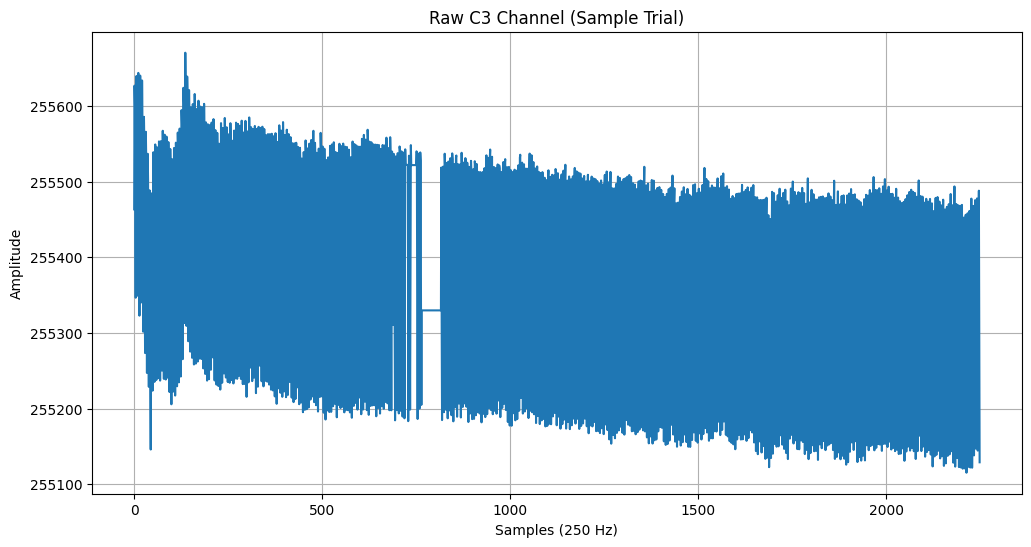

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sample_trial['C3'].values[:])  # First 2 seconds
plt.title("Raw C3 Channel (Sample Trial)")
plt.ylabel("Amplitude")
plt.xlabel("Samples (250 Hz)")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Power [dB]')

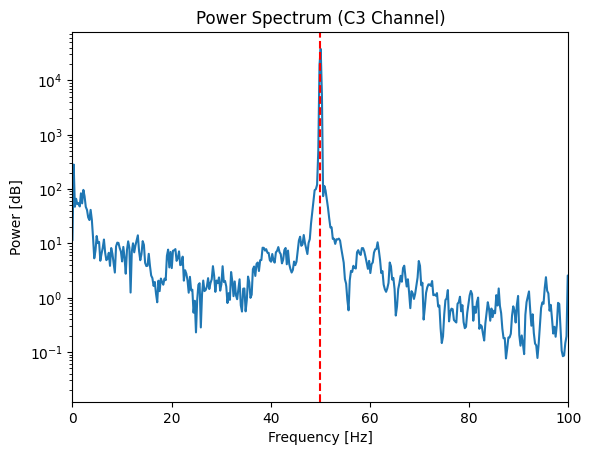

In [4]:
from scipy import signal

f, Pxx = signal.welch(sample_trial['C3'], 250, nperseg=1024)
plt.semilogy(f, Pxx)
plt.xlim(0, 100)
plt.axvline(50, color='r', linestyle='--')
plt.title("Power Spectrum (C3 Channel)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")

In [5]:
from scipy import signal

# Check 50Hz periodicity in C3
c3_data = sample_trial['C3'].values
autocorr = np.correlate(c3_data - np.mean(c3_data), c3_data - np.mean(c3_data), mode='full')
peaks, _ = signal.find_peaks(autocorr[len(autocorr)//2:])

if len(peaks) > 1:
    period_samples = peaks[1] - peaks[0]
    print(f"Dominant period: {period_samples} samples")
    print(f"Equivalent frequency: {250/period_samples:.1f} Hz")

Dominant period: 5 samples
Equivalent frequency: 50.0 Hz


In [6]:
# Calculate noise floor (1-45Hz excluding line noise)
freq_mask = (f > 1) & (f < 45) & (np.abs(f - 50) > 2) & (np.abs(f - 100) > 2)
noise_floor = np.median(Pxx[freq_mask])
print(f"Noise floor: {noise_floor:.2e} dB")
print(f"50Hz peak is {Pxx[np.argmin(np.abs(f-50))]/noise_floor:.1f}x above noise floor")

Noise floor: 4.15e+00 dB
50Hz peak is 9084.6x above noise floor


In [7]:
import numpy as np
import pandas as pd
import os
from scipy import signal
import matplotlib.pyplot as plt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './mtc-aic3_dataset_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_SENSORS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
FS = 250  # Sampling rate (Hz)

def load_full_trial(row):
    """Load complete trial data with all columns"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Build file path
    eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    trial_duration = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * trial_duration
    end_idx = start_idx + trial_duration
    return full_data.iloc[start_idx:end_idx].copy()

def preprocess_trial(trial_data, task):
    """Comprehensive preprocessing pipeline for EEG data"""
    # 1. Convert nV to μV
    eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
    
    # 2. Extract validation flags and motion sensors
    validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
    motion_data = trial_data[MOTION_SENSORS].copy() if all(col in trial_data for col in MOTION_SENSORS) else None
    
    # 3. Remove DC offset (using median for robustness)
    eeg_data = eeg_data - np.median(eeg_data, axis=0)
    
    # 4. Handle invalid segments using Validation flags
    if validation_flags is not None:
        for i, channel in enumerate(EEG_CHANNELS):
            # Identify invalid segments
            invalid_idx = np.where(validation_flags == 0)[0]
            
            if len(invalid_idx) > 0:
                # Create mask for valid data points
                valid_mask = np.ones(len(eeg_data), dtype=bool)
                valid_mask[invalid_idx] = False
                
                # Create interpolation function
                x = np.arange(len(eeg_data))
                eeg_data[channel] = np.interp(x, x[valid_mask], eeg_data[channel].values[valid_mask])
    
    # 5. Handle clipping artifacts
    def fix_clipping(channel_data):
        """Detect and interpolate clipped segments"""
        max_val = np.max(channel_data)
        min_val = np.min(channel_data)
        
        # Detect clipping (within 1% of max/min)
        clipped_high = channel_data > 0.99 * max_val
        clipped_low = channel_data < 0.99 * min_val
        clipped_mask = clipped_high | clipped_low
        
        if np.any(clipped_mask):
            # Create interpolation function
            x = np.arange(len(channel_data))
            return np.interp(x, x[~clipped_mask], channel_data[~clipped_mask])
        return channel_data
    
    eeg_data = eeg_data.apply(fix_clipping, axis=0)
    
    # 6. Motion artifact detection and removal
    if motion_data is not None:
        # Compute motion magnitude
        acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
        gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
        motion_index = acc_mag + gyro_mag
        
        # Detect motion artifacts (z-score > 3)
        motion_z = (motion_index - np.mean(motion_index)) / np.std(motion_index)
        motion_artifacts = motion_z > 3
        
        if np.any(motion_artifacts):
            for channel in EEG_CHANNELS:
                # Create mask for non-artifact segments
                clean_mask = ~motion_artifacts
                
                # Create interpolation function
                x = np.arange(len(eeg_data))
                eeg_data[channel] = np.interp(x, x[clean_mask], eeg_data[channel].values[clean_mask])
    
    # 7. Advanced filtering pipeline
    # Step 1: High-pass filter (1Hz cutoff)
    sos_hp = signal.butter(4, 1, btype='highpass', output='sos', fs=FS)
    filtered = signal.sosfiltfilt(sos_hp, eeg_data.values, axis=0)
    
    # Step 2: Notch filters (50Hz and harmonics)
    def apply_notch(data, f0):
        b, a = signal.iirnotch(f0, Q=30, fs=FS)
        return signal.filtfilt(b, a, data, axis=0)
    
    filtered = apply_notch(filtered, 50)
    filtered = apply_notch(filtered, 100)  # 2nd harmonic
    
    # Step 3: Bandpass filter (1-45 Hz)
    sos_bp = signal.butter(4, [1, 45], btype='bandpass', output='sos', fs=FS)
    filtered = signal.sosfiltfilt(sos_bp, filtered, axis=0)
    
    # Update EEG data with filtered values
    eeg_data = pd.DataFrame(filtered, columns=EEG_CHANNELS)
    
    return eeg_data

def save_preprocessed_data(preprocessed_data, row):
    """Save preprocessed data to organized directory structure"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Create output directory
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as compressed numpy file
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    
    return output_path

# Main preprocessing function
def preprocess_dataset(df, dataset_name):
    """Preprocess entire dataset and save results"""
    print(f"Preprocessing {dataset_name} set with {len(df)} trials...")
    
    processed_paths = []
    for idx, row in df.iterrows():
        # Load full trial data
        trial_data = load_full_trial(row)
        
        # Apply preprocessing pipeline
        preprocessed = preprocess_trial(trial_data, row['task'])
        
        # Save processed data
        output_path = save_preprocessed_data(preprocessed, row)
        processed_paths.append(output_path)
        
        # Print progress
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx+1}/{len(df)} trials")
    
    # Add paths to dataframe
    df['processed_path'] = processed_paths
    
    # Save updated dataframe
    df.to_csv(f"{PREPROCESSED_PATH}/{dataset_name}.csv", index=False)
    print(f"Finished preprocessing {dataset_name} set\n")

# Create output directory
os.makedirs(PREPROCESSED_PATH, exist_ok=True)

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Preprocess all datasets
preprocess_dataset(train_df, 'train')
preprocess_dataset(val_df, 'validation')
preprocess_dataset(test_df, 'test')

print("Preprocessing complete! Data saved to:", PREPROCESSED_PATH)

Preprocessing train set with 4800 trials...
Processed 100/4800 trials
Processed 200/4800 trials
Processed 300/4800 trials
Processed 400/4800 trials
Processed 500/4800 trials
Processed 600/4800 trials
Processed 700/4800 trials
Processed 800/4800 trials
Processed 900/4800 trials
Processed 1000/4800 trials
Processed 1100/4800 trials
Processed 1200/4800 trials
Processed 1300/4800 trials
Processed 1400/4800 trials
Processed 1500/4800 trials
Processed 1600/4800 trials
Processed 1700/4800 trials
Processed 1800/4800 trials
Processed 1900/4800 trials
Processed 2000/4800 trials
Processed 2100/4800 trials
Processed 2200/4800 trials
Processed 2300/4800 trials
Processed 2400/4800 trials
Processed 2500/4800 trials
Processed 2600/4800 trials
Processed 2700/4800 trials
Processed 2800/4800 trials
Processed 2900/4800 trials
Processed 3000/4800 trials
Processed 3100/4800 trials
Processed 3200/4800 trials
Processed 3300/4800 trials
Processed 3400/4800 trials
Processed 3500/4800 trials
Processed 3600/4800 

In [8]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/mtc-aic3_dataset_preprocessed'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Load from the processed_path column added during preprocessing
    data = np.load(row['processed_path'])['data']
    return pd.DataFrame(data, columns=EEG_CHANNELS)

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    f, psd = signal.welch(channel_data, FS, nperseg=256)
    
    # Find target frequency bin
    target_idx = np.argmin(np.abs(f - target_freq))
    target_power = psd[target_idx]
    
    # Define surrounding noise bands
    low_band = (target_freq - 5, target_freq - 1)
    high_band = (target_freq + 1, target_freq + 5)
    
    # Calculate average noise power
    noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
    noise_power = np.mean(psd[noise_mask])
    
    # Avoid division by zero
    if noise_power < 1e-10:
        return 0
    
    # Compute SNR ratio
    return target_power / noise_power

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    variances = [m['variance'] for m in channel_metrics]
    q1, q3 = np.percentile(variances, [25, 75])
    iqr = q3 - q1
    for i, metrics in enumerate(channel_metrics):
        if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
            noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += 1
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['total_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['total_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        print("\nNoise Type Counts:")
        for ntype in res['noise_report']:
            if ntype not in ['total_trials', 'noisy_trials', 'noisy_percentage']:
                print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Noisy trials: 95.85%

Noise Type Counts:
- flat_channels: 2695 channels
- abnormal_voltage: 2 channels
- high_range: 11 channels
- high_kurtosis: 4404 channels
- line_noise_50Hz: 1345 channels
- line_noise_60Hz: 18 channels
- variance_outliers: 2942 channels

Signal Metrics (across all channels):
- variance: mean=0.2485, median=0.0089
- range: mean=2.7606, median=1.4700
- kurtosis: mean=27.3904, median=22.6605
- snr_50: mean=1.7988, median=0.6225
- snr_60: mean=0.4756, median=0.4266

Contralateral pattern adherence: 49.67% of MI trials

===== VALIDATION SET RESULTS =====
Noisy trials: 95.00%

Noise Type Counts:
- flat_channels: 23 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 79 channels
- line_noise_50Hz: 14 channels
- line_noise_60Hz: 1 channels
- variance_outliers: 63 channels

Signal Metrics (across all channels):
- variance: mean=1.7898, media